# Emcee Testing

## Simple Lorentzian No Background - Works Great

In [24]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 10000
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
true_kappa = kappa
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

#sig_dist = sp.stats.halfcauchy
#signal = sig_dist.rvs(scale=kappa, loc=0.0, size=nsig)

bg = np.random.uniform(xrange[0], xrange[1], nbg)

events = curv.data
#events = np.concatenate((curv.data, bg))


[0.0001]
Generated 10000 samples using parameters [0.01111111]


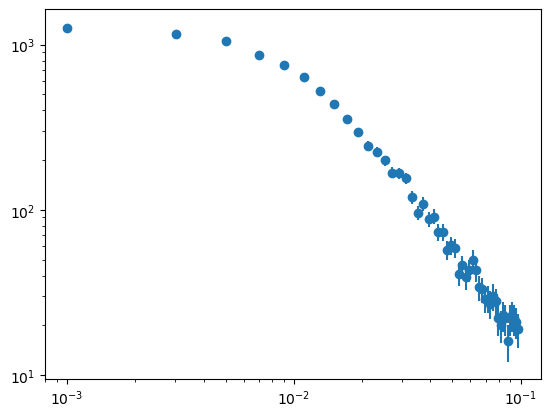

In [25]:
qmin = np.amin(events)
qmax = np.amax(events)
bins = np.linspace(qmin, qmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [26]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim:
        return 0.0
    
    return -np.inf

def pmf(xvals, theta):
    
    kappa = np.asarray(theta)
    
    result = curv.curve(kappa, dat=xvals)    
    return result


def log_likelihood(theta):
    kappa = np.asarray(theta)
    
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    ll = curv.llcurve(kappa)
    
    result = lp + ll
    
    if np.isnan(result):
        print("NaN result for theta, prior", theta, lp)
    
    return result


p0 = np.array([0.02])


print(log_likelihood(p0))

21828.542754319402


In [30]:
ndim, nwalkers = 1, 32

p0 = np.array(0.02)

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 2000, progress=True);

100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 307.34it/s]


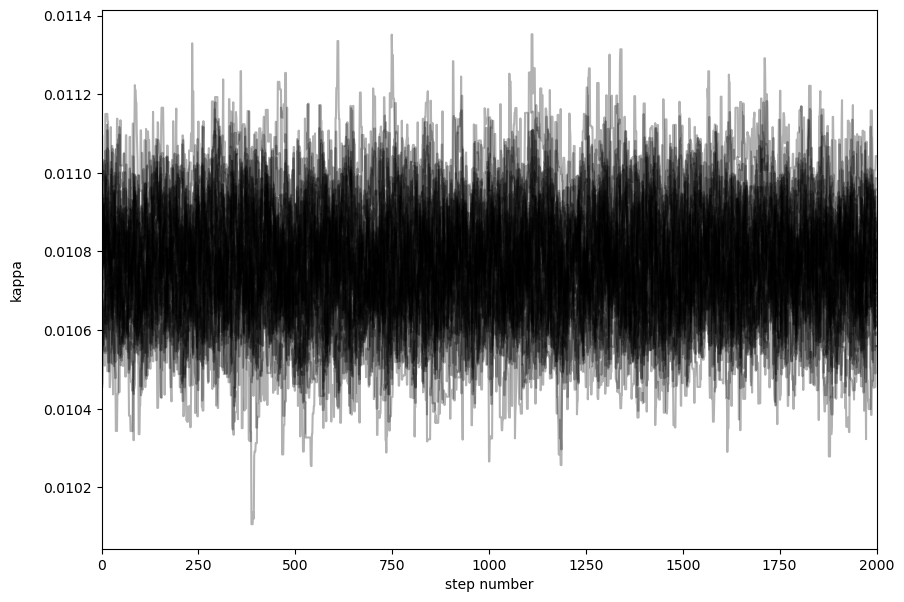

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa"]
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples))
ax.set_ylabel(labels[0])
ax.yaxis.set_label_coords(-0.1, 0.5)

ax.set_xlabel("step number");

Acceptance fraction 0.805


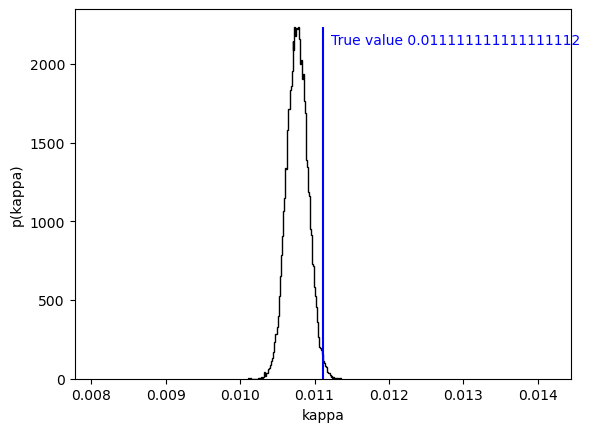

In [50]:
samples=sampler.get_chain(flat=True)

labeltxt = "True value " + str(true_kappa)

ytop = np.amax(hst[0])

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop, color='blue')
plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.01, ytop*0.95, labeltxt, color="blue")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction))

Text(0.5, 0, 'Q (Å-1)')

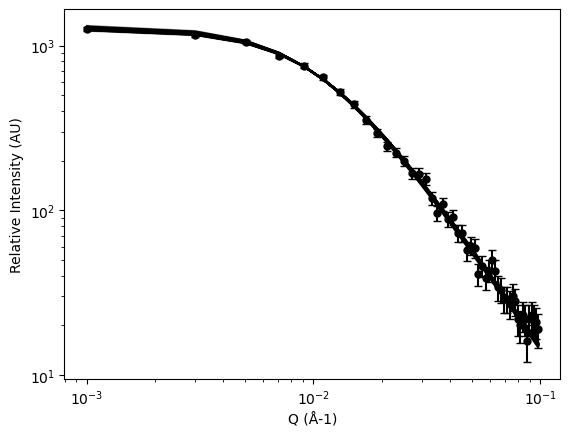

In [51]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')

## Lorentzian With Flat Background - Not working yet

In [19]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 10000

ratio = float(nsig) / float(nbg)
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
true_kappa = kappa
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

curv.generate_background(xrange, ratio = ratio)


events = curv.data

[0.0001]
Generated 10000 samples using parameters [0.01111111]
Adding flat background of 10000.0 points


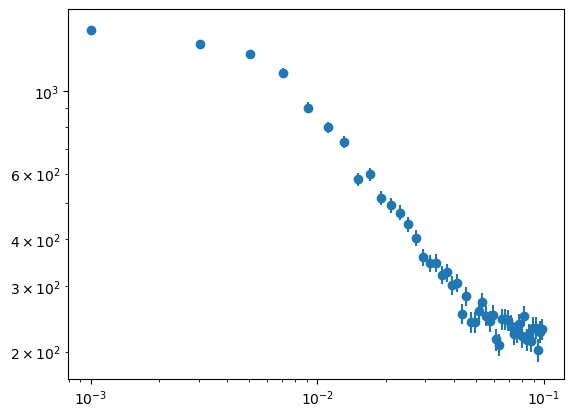

In [2]:
xmin = np.amin(events)
xmax = np.amax(events)
bins = np.linspace(xmin, xmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [100]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, logQ = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and -4.0 < logQ < 0.0:# and 0.1 < sigma < 3.0:
        return 0.0
    
    return -np.inf

def bg_integral(xmin, xmax):
    # Returns the integral over the range of x values
    
    # Assume y=1 over the range
    return xmax-xmin

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def get_weights(xvals, theta):
    # Figure out the color weight of the point based on its signal likelihood
    kappa, logQ = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    bg_y = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    
#   This is an extreme cut test to see if other functions are working properly
#    mask = xvals > 4.0E-02
#    yweight = np.ones_like(xvals)   
#    yweight[mask] = 0.0
    
    
    return yweight

def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, logQ = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (1.0/bg_int + yvals/sig_int)
    
    color_r = np.full_like(yweight, 1.0)
    color_g = yweight
    color_b = 1.0-yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xx, theta, verbose=False):
    gaus = sp.stats.norm
    
    kappa, logQ = theta
    
    bgvals = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xx)
    
    yweight = get_weights(xvals, theta)
    
    term1 = yvals / yweight
    term2 = bgvals / (1.0 - yweight) #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    if verbose:
        print("term 1:", term1)
        print("term 2:", term2)
    
    result = term1 + term2
    
    return result

def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta, testing=False):
    kappa, logQ = theta
    
    if testing:
        verbose=True
        study_data = xvals
    else:
        verbose=False
        study_data = events
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)

    
    
    sig_Q = curv.curve(np.array([kappa]), dat=study_data) #/ sig_int
    bgQval = 10.0**logQ 

    bgQ = np.full_like(sig_Q, bgQval)
    

    weights = (sig_Q/sig_int) / (bgQ/bg_int + sig_Q/sig_int)

    weights = get_weights(study_data, theta)
            
        
    
    bg_weights = 1.0 - weights
    
    log_weights = np.log(weights)
    log_bg_weights = np.log(bg_weights) 
    ll = np.log(sig_Q)
    lbg = np.log(bgQ)
    
    weighted_ll = ll - log_weights
    weighted_lbg = lbg - log_bg_weights#*0.3 #* (1.0-weights)
    
    weighted_ll_sum = np.sum( np.logaddexp(weighted_ll, weighted_lbg))
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    
    if np.isnan(result):
        verbose=True
    
    if verbose:
        print("bg_int", bg_int)
        print("sig_int", sig_int)
    
        print("xvals", xvals)
        print("xrange", xmin, xmax)
    
        print("sig_Q", sig_Q)
        print("bgQ", bgQ)
        
        print("weights", weights)
        print("bg_weights", 1.0-weights)
        
        print("weighted ll", weighted_ll)
        print("weighted lbg", weighted_lbg)
    
    return result


p0 = np.array([0.01, -0.5])

print(cauchy_integral(xmin, xmax, 0.01))

p_correct_fit = np.array([0.01111, -0.001])

#pmf(xvals, p_wrong_fit, verbose=True)

print(log_likelihood(p_correct_fit, testing=True))


0.43648405066149193
bg_int 0.09897148058962277
sig_int 0.43614616977736953
xvals [0.00100179 0.00302162 0.00504144 0.00706127 0.0090811  0.01110092
 0.01312075 0.01514058 0.0171604  0.01918023 0.02120005 0.02321988
 0.02523971 0.02725953 0.02927936 0.03129918 0.03331901 0.03533884
 0.03735866 0.03937849 0.04139832 0.04341814 0.04543797 0.04745779
 0.04947762 0.05149745 0.05351727 0.0555371  0.05755692 0.05957675
 0.06159658 0.0636164  0.06563623 0.06765605 0.06967588 0.07169571
 0.07371553 0.07573536 0.07775519 0.07977501 0.08179484 0.08381466
 0.08583449 0.08785432 0.08987414 0.09189397 0.09391379 0.09593362
 0.09795345]
xrange 0.001001792433250197 0.09997327302287297
sig_Q [28.41968321 26.67744451 23.75857618 20.40711198 17.17557035 14.33708606
 11.96410153 10.02759416  8.46213374  7.19789862  6.17312095  5.33723201
  4.65028236  4.08120589  3.60597148  3.2059792   2.8667766   2.577069
  2.32796963  2.11243541  1.92484302  1.76066951  1.61625073  1.48859753
  1.37525502  1.2741942   

In [96]:
ndim, nwalkers = 2, 32

p0 = np.array([0.02, -0.5])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

100%|███████████████████████████████████████| 500/500 [00:20<00:00, 24.78it/s]


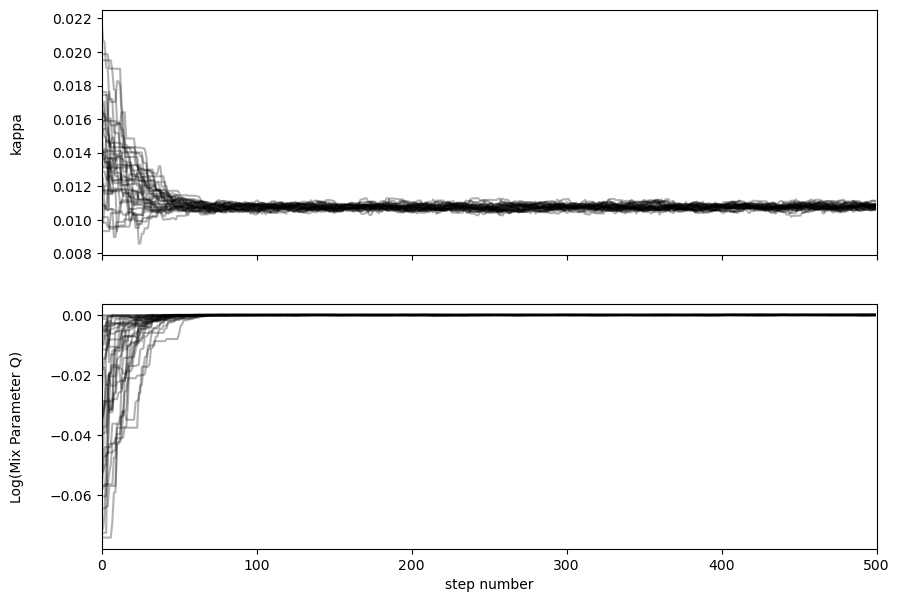

In [97]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "Log(Mix Parameter Q)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Text(0, 0.5, 'Point Signal Weight')

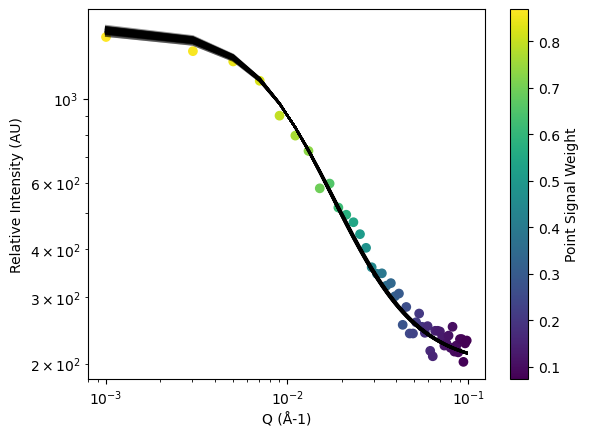

In [101]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(xvals, yvals, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
cbar = fig.colorbar(sct)
cbar.ax.set_ylabel('Point Signal Weight')


Acceptance fraction 0.6265624999999999 (should be high)


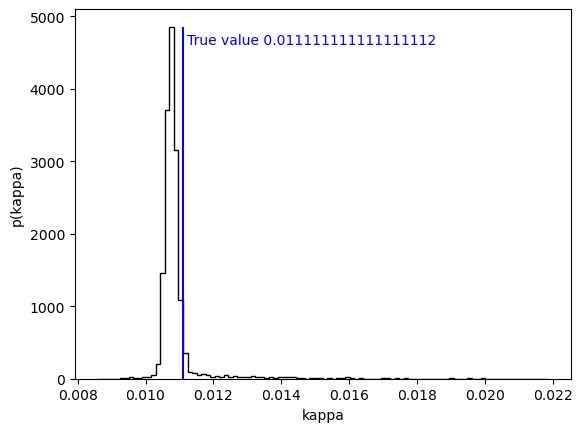

In [102]:
samples=sampler.get_chain(flat=True)

labeltxt = "True value " + str(true_kappa)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop, color='blue')
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.01, ytop*0.95, labeltxt, color="blue")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")

## Lorentzian With Systematic Background

In [245]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee

import emtk.curves.lorentzian as lor
import emtk.curves.gaussian as gauss


nsig = 10000
nbg = 10000

ratio = float(nsig) / float(nbg)
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
curv = lor.LorentzianCurve()

pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)


gau = gauss.GaussianCurve()
mu = 0.06
sigma = 0.005
gvalues = np.array([mu, sigma])

bg.generate_test_samples(gvalues, xrange, nbg)


events = np.concatenate((curv.data, bg.data))

np.random.shuffle(events)
curv.data = events

[0.0001]
Generated 10000 samples using parameters [0.01111111]
Generated 10000 samples using parameters [0.06  0.005]


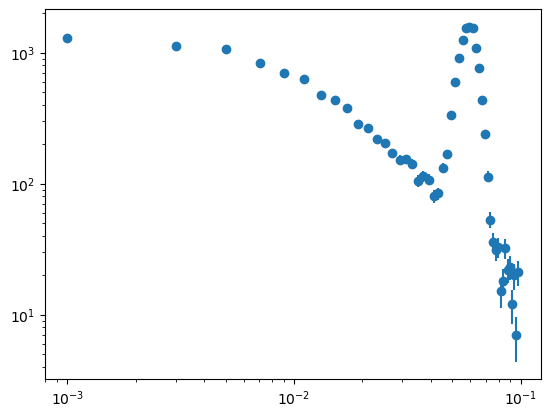

In [246]:
xmin = np.amin(events)
xmax = np.amax(events)
bins = np.linspace(xmin, xmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [249]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, Q, mu, sigma = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and 0.0 < Q < 1.0 and lolim < mu < hilim and lolim < sigma < 0.03:
        return 0.0
    
    return -np.inf

def gaussian_integral(xmin, xmax, mu, sigma):
    erf = sp.special.erf
    root2 = np.sqrt(2.0)
    t1 = (xmax-mu)/(root2 * sigma)
    t2 = (xmin-mu)/(root2 * sigma)
    
    result = 0.5 * (erf(t1)-erf(t2))
    
    return result
    

def bg_integral(xmin, xmax):
    # Returns the integral over the range of x values
    
    # Assume y=1 over the range
    return xmax-xmin

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi



def get_weights(xvals, theta):
    # Figure out the color weight of the point based on its signal likelihood
    kappa, Q, mu, sigma = theta
    
    bg_int = gaussian_integral(xmin, xmax, mu, sigma)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    bg_y = gau.curve(np.array([mu, sigma]), dat=xvals)
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    
#   This is an extreme cut test to see if other functions are working properly
#    mask = xvals > 4.0E-02
#    yweight = np.ones_like(xvals)   
#    yweight[mask] = 0.0
    
    
    return yweight



def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, Q, mu, sigma = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (1.0/bg_int + yvals/sig_int)
    
    color_r = np.full_like(yweight, 1.0)
    color_g = yweight
    color_b = 1.0-yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xvals, theta, verbose=False):
    gaus = sp.stats.norm
    
    kappa, Q, mu, sigma = theta
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    bgvals= gau.curve(np.array([mu, sigma]), dat=xvals)
    
    yweight = get_weights(xvals, theta)
    
    term1 = yvals * yweight
    term2 = bgvals * (1.0 - yweight) #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    if verbose:
        print("term 1:", term1)
        print("term 2:", term2)
    
    result = term1 + term2
    
    return result

                        
def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta, testing=True):
    kappa, Q, mu, sigma = theta
    
    if testing:
        verbose=True
        study_data = xvals
    else:
        verbose=False
        study_data = events
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)

    if verbose:
        print("bg_int", bg_int)
        print("sig_int", sig_int)
    
        print("xvals", xvals)
        print("xrange", xmin, xmax)
    
    sig_Q = curv.curve(np.array([kappa]), dat=study_data) #/ sig_int
    bgQ = gau.curve(np.array([mu, sigma]), dat=study_data)

    
    if verbose:
        print("sig_Q", sig_Q)
        print("bgQ", bgQ)
    weights = (sig_Q/sig_int) / (bgQ/bg_int + sig_Q/sig_int)

    weights = get_weights(study_data, theta)
    
    if verbose:
        print("weights", weights)
        print("bg_weights", 1.0-weights)
        
    
    bg_weights = 1.0 - weights
    
    #log_weights = np.log(weights)
    #log_bg_weights = np.log(bg_weights) 
    ll = np.log(sig_Q)
    lbg = np.log(bgQ)
    
    weighted_ll = ll * weights# + log_weights
    weighted_lbg = lbg * (1.0-weights)
    
    weighted_ll_sum = np.sum( np.logaddexp(weighted_ll, weighted_lbg))
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    
    if np.isnan(result):
        print("nan encountered at", theta)
    
    return result


p0 = np.array([0.01, 0.5, 0.01, 0.01])
#print(log_likelihood(p0))

p1 = np.array([0.01496048, 0.50451563, 0.02575426, 0.00161801])
print(log_likelihood(p1))
#p_wrong_fit = np.array([0.026, 0.5])

#pmf(xvals, p_wrong_fit, verbose=True)

bg_int 0.09865832014740804
sig_int 0.43131864448899276
xvals [0.00100031 0.00301375 0.00502718 0.00704062 0.00905405 0.01106749
 0.01308092 0.01509436 0.01710779 0.01912123 0.02113466 0.0231481
 0.02516153 0.02717497 0.0291884  0.03120184 0.03321527 0.03522871
 0.03724214 0.03925558 0.04126901 0.04328245 0.04529588 0.04730932
 0.04932275 0.05133619 0.05334962 0.05536306 0.05737649 0.05938993
 0.06140336 0.0634168  0.06543023 0.06744367 0.06945711 0.07147054
 0.07348398 0.07549741 0.07751085 0.07952428 0.08153772 0.08355115
 0.08556459 0.08757802 0.08959146 0.09160489 0.09361833 0.09563176
 0.0976452 ]
xrange 0.001000311558738507 0.09965863170614654
sig_Q [21.18201682 20.4469587  19.11797749 17.41883041 15.57291068 13.75107346
 12.05811421 10.54358422  9.22001477  8.079008    7.10237172  6.26876357
  5.55720013  4.94865863  4.42662426  3.97710486  3.58840715  3.25082987
  2.95635011  2.69833659  2.47130179  2.27069413  2.09272666  1.93423746
  1.79257632  1.66551305  1.55116326  1.44792

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2973732451.py:174: RuntimeWarning: divide by zero encountered in log
  lbg = np.log(bgQ)
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2973732451.py:177: RuntimeWarning: invalid value encountered in multiply
  weighted_lbg = lbg * (1.0-weights)


In [238]:
ndim, nwalkers = 4, 32

p0 = np.array([0.02, 0.5, 0.01, 0.01])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

nan encountered at [0.01496048 0.50451563 0.02575426 0.00161801]


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2212396294.py:174: RuntimeWarning: divide by zero encountered in log
  lbg = np.log(bgQ)
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2212396294.py:177: RuntimeWarning: invalid value encountered in multiply
  weighted_lbg = lbg * (1.0-weights)


ValueError: Probability function returned NaN

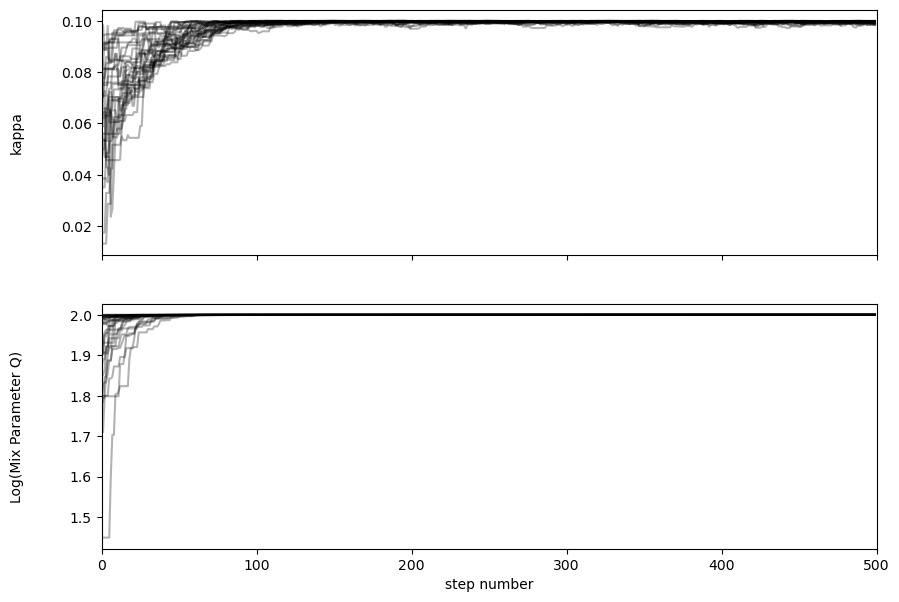

In [214]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "Log(Mix Parameter Q)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Text(0, 0.5, 'Point Signal Weight')

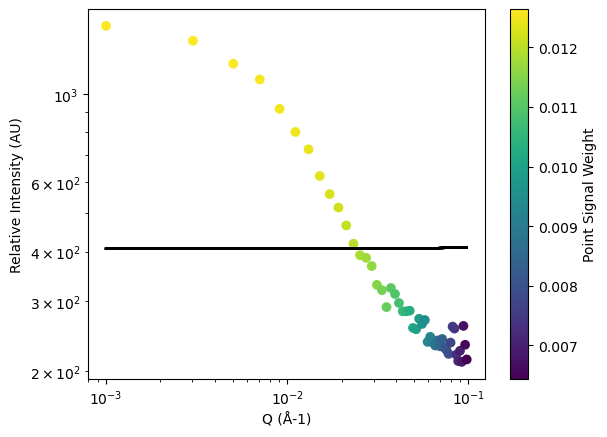

In [215]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(xvals, yvals, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
cbar = fig.colorbar(sct)
cbar.ax.set_ylabel('Point Signal Weight')


Acceptance fraction 0.34481249999999997 (should be high)


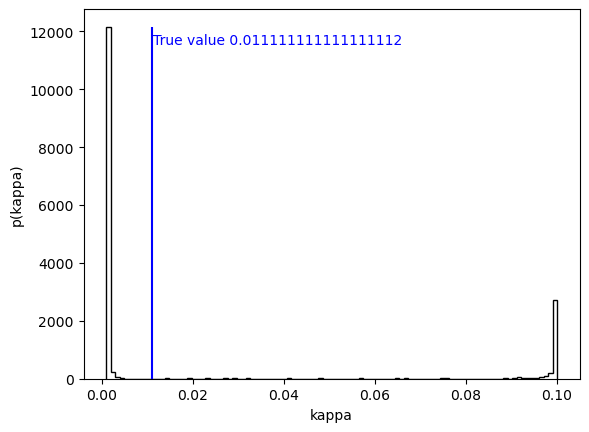

In [211]:
samples=sampler.get_chain(flat=True)

labeltxt = "True value " + str(true_kappa)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop, color='blue')
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.01, ytop*0.95, labeltxt, color="blue")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")